In [1]:
import torch
import torch.nn.functional as F
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import MDS
import seaborn as sns

repo_root = os.path.abspath(os.path.join(os.getcwd(), "..", ".."))
sys.path.append(repo_root)

from tqdm import tqdm

from src.utils import CIFAR
from src.model import CIFAR_CNN

import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.cm as cm

In [22]:
def stochastic_gradient_sampling(model, optimizer, train_loader, criterion, device, ckpt_folder):
    model.train()
    os.makedirs(ckpt_folder, exist_ok=True)
    
    for i, (images, labels) in enumerate(tqdm(train_loader, desc="Computing gradient differences")):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        gradient = {name: param.grad.clone() for name, param in model.named_parameters()}
        
        torch.save(gradient, os.path.join(ckpt_folder, f'gradients_{i}.pt'))
        
def evaluate_sgd_update(model, gradient, lr, test_loader, criterion, device):
    model_copy = torch.nn.Module()  # Создаем копию модели
    model_copy.load_state_dict(model.state_dict())
    
    with torch.no_grad():
        for name, param in model_copy.named_parameters():
            if name in gradient:
                param -= lr * gradient[name]
    
    model_copy.eval()
    total_loss = 0.0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model_copy(images)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
    
    return total_loss / len(test_loader)

def compute_gradient_distances(ckpt_folder):
    gradient_files = sorted(f for f in os.listdir(ckpt_folder) if f.startswith("gradients_") and f.endswith(".pt"))
    distance_dict = {}
    
    for name in torch.load(os.path.join(ckpt_folder, gradient_files[0])).keys():
        distance_dict[name] = torch.zeros((len(gradient_files), len(gradient_files)))
    
    for i in tqdm(range(len(gradient_files)), desc=f"Processing gradients (i)"):
        gradient_i = torch.load(os.path.join(ckpt_folder, gradient_files[i]))
        
        for j in tqdm(range(i + 1, len(gradient_files)), desc=f"Processing gradients (j) for i={i}", leave=False):
            gradient_j = torch.load(os.path.join(ckpt_folder, gradient_files[j]))
            
            for name in gradient_i:
                cos_sim = F.cosine_similarity(gradient_i[name].flatten(), gradient_j[name].flatten(), dim=0)
                distance = 1 - cos_sim.item()
                distance_dict[name][i, j] = distance
                distance_dict[name][j, i] = distance  # Симметричное заполнение
    return distance_dict

def visualize_mds(distance_matrix):
    mds = MDS(n_components=2, dissimilarity='precomputed', random_state=42)
    coords = mds.fit_transform(distance_matrix)
    
    plt.figure(figsize=(8, 6))
    plt.scatter(coords[:, 0], coords[:, 1], c='blue', label='Gradients')
    
    for i, (x, y) in enumerate(coords):
        plt.text(x, y, str(i), fontsize=9, ha='right')
    
    plt.xlabel("MDS Component 1")
    plt.ylabel("MDS Component 2")
    plt.title("MDS Visualization of Gradient Distances")
    plt.legend()
    plt.grid(True)
    plt.show()

def extract_gradients(ckpt_folder, flattened = True):
    gradient_files = sorted(f for f in os.listdir(ckpt_folder) if f.startswith("gradients_") and f.endswith(".pt"))
    gradients = {}
    
    for i, file in enumerate(tqdm(gradient_files, desc="Loading gradients")):
        gradient = torch.load(os.path.join(ckpt_folder, file))
        
        for name, tensor in gradient.items():
            if name not in gradients:
                gradients[name] = []
            
            gradients[name].append(tensor.flatten().cpu().detach().numpy() if flattened else tensor.cpu().detach().numpy())
            
    return gradients

def visualize_mds_from_gradients(gradient_vectors):
    gradient_matrix = torch.stack(gradient_vectors).cpu().numpy()  # Перемещение на CPU
    mds = MDS(n_components=2, dissimilarity='euclidean', random_state=42)
    coords = mds.fit_transform(gradient_matrix)
    
    plt.figure(figsize=(8, 6))
    plt.scatter(coords[:, 0], coords[:, 1], c='blue', label='Gradients')
    
    for i, (x, y) in enumerate(coords):
        plt.text(x, y, str(i), fontsize=9, ha='right')
    
    plt.xlabel("MDS Component 1")
    plt.ylabel("MDS Component 2")
    plt.title("MDS Visualization of Gradient Vectors")
    plt.legend()
    plt.grid(True)
    plt.show()

In [3]:
DEVICE = "mps"

# Папка с чекпоинтами
CHECKPOINT_MODELS = f"{repo_root}/data/checkpoints/exp6"
CHECKPOINT_DIR = f"{repo_root}/data/checkpoints/exp9"


In [4]:

checkpoint_path = os.path.join(CHECKPOINT_MODELS, "model_seed_0_epoch_20.pth")
model = CIFAR_CNN().to(DEVICE)
model.load_state_dict(torch.load(checkpoint_path))

<All keys matched successfully>

In [28]:
batch_size = 8
train_dataset, test_dataset, train_loader, test_loader = CIFAR(batch_size=batch_size, sample_size=800)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001)
criterion = torch.nn.CrossEntropyLoss()
stochastic_gradient_sampling(model, optimizer, train_loader, criterion, DEVICE, ckpt_folder=CHECKPOINT_DIR)


Computing gradient differences: 100%|██████████| 100/100 [00:03<00:00, 26.13it/s]


In [31]:
distances = compute_gradient_distances(ckpt_folder=CHECKPOINT_DIR)

Processing gradients (i): 100%|██████████| 100/100 [01:31<00:00,  1.10it/s]


In [39]:
gradients = extract_gradients(ckpt_folder=CHECKPOINT_DIR)

Loading gradients: 100%|██████████| 100/100 [00:01<00:00, 95.30it/s]


In [45]:
keys = list(gradients.keys())
keys

['conv1.weight',
 'conv1.bias',
 'conv2.weight',
 'conv2.bias',
 'conv3.weight',
 'conv3.bias',
 'conv4.weight',
 'conv4.bias',
 'conv5.weight',
 'conv5.bias',
 'conv6.weight',
 'conv6.bias',
 'bn64.weight',
 'bn64.bias',
 'bn128.weight',
 'bn128.bias',
 'bn256.weight',
 'bn256.bias',
 'bn512.weight',
 'bn512.bias',
 'fc.weight',
 'fc.bias']

In [44]:

# for key in keys:
#     visualize_mds_from_gradients(gradients[key])

## Visualise gradients

In [23]:
gradients = extract_gradients(ckpt_folder=CHECKPOINT_DIR, flattened=False)

Loading gradients: 100%|██████████| 100/100 [00:01<00:00, 52.67it/s]


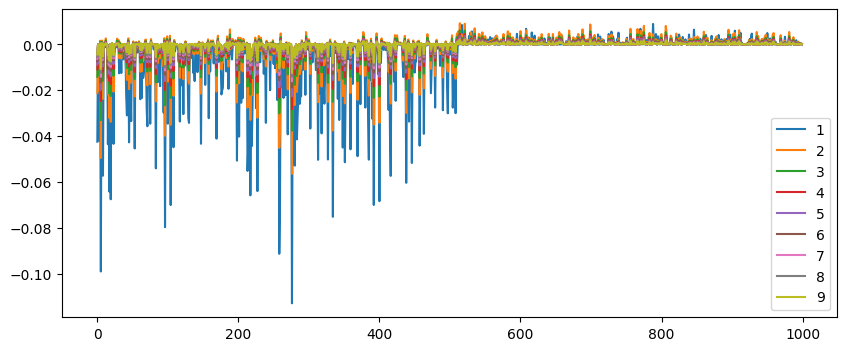

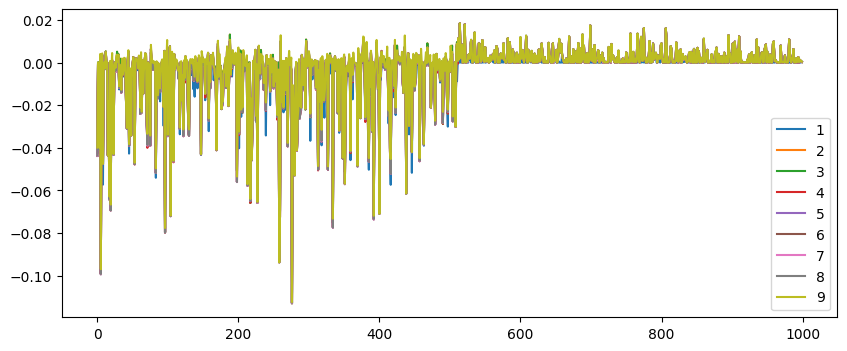

In [49]:
plt.figure(figsize=(10,4) )

for m in range(1,10):
    weight = np.mean(gradients['fc.weight'][:m] , axis=0)
    
    # weight = weight * ( weight**2 > 1e-3)
    
    plt.plot(weight.reshape(-1)[:1000] , label = f'{m}')
plt.legend()
plt.show()

plt.figure(figsize=(10,4) )

for m in range(1,10):
    weight = np.sum(gradients['fc.weight'][:m] , axis=0)
    
    # weight = weight * ( weight**2 > 1e-3)
    
    plt.plot(weight.reshape(-1)[:1000] , label = f'{m}')
plt.legend()
plt.show()



## а что если на больших батчах юзать loss(reduction = 'sum' ) вместо loss(reduciton = 'mean')